In [1]:
import vaex
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import numpy as np


In [2]:
from pygadget import Simulation

In [3]:
fname = '/data/patricia/MARE/147062_chabrier_1024/snap_147062_L12_128'

snap = Simulation(fname, pot=True)
print(snap)

file: /data/patricia/MARE/147062_chabrier_1024/snap_147062_L12_128
file number: 1
endianess: <
particle numbers: {'gas': 24920562, 'halo': 28224328, 'disk': 725391, 'bulge': 320975, 'stars': 9291717, 'bndry': 2090693}
particle mass: {'gas': 0.0, 'halo': 1.357926689761371e-05, 'disk': 0.0001284225145354867, 'bulge': 0.0, 'stars': 0.0, 'bndry': 0.5260186195373535}
cosmic time: 1.0
redshift: 0.0
box size: 50000.0
omega_matter: 0.3175
omega_lambda: 0.6825
h: 0.6711
flags: {'pot': True, 'accel': False, 'endt': False, 'tstp': False, 'sfr': 1, 'feedback': 1, 'cooling': 1, 'stellar_age': 1, 'metals': 1, 'entr_ics': 0}


In [4]:
dm_pos = snap.read_block('pos', 'halo')
dm_pot = snap.read_block('pot', 'halo')
stars_pos = snap.read_block('pos', 'stars')
gas_pos = snap.read_block('pos', 'gas')
bndry_pos = snap.read_block('pos', 'disk')

In [5]:
# Load rockstar data for central halo

snapnum = 128

columns = ['hid', 'descid', 'mvir', 'vmax', 'vrms', 'rvir', 'rs', 'np', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'jx',
           'jy', 'jz','spin', 'rs_klypin', 'mvir_all', 'm200b', 'm200c', 'm500c', 'm2500c', 'xoff', 'voff',
           'spin_bullock', 'b_to_a', 'c_to_a', 'ax', 'ay', 'az', 'b_to_a_500c', 'pid',]

rockstar_fname = '/home/lbignone/Results/MARE_analysis/147062_chabrier_1024/' + 'halos/out_{:d}.list'.format(snapnum)

halos = np.genfromtxt(rockstar_fname, names=columns)
halos = pd.DataFrame(halos)
halos = halos.sort_values('mvir', ascending=False)

central_i = halos['mvir'].idxmax()

central = halos.iloc[0]

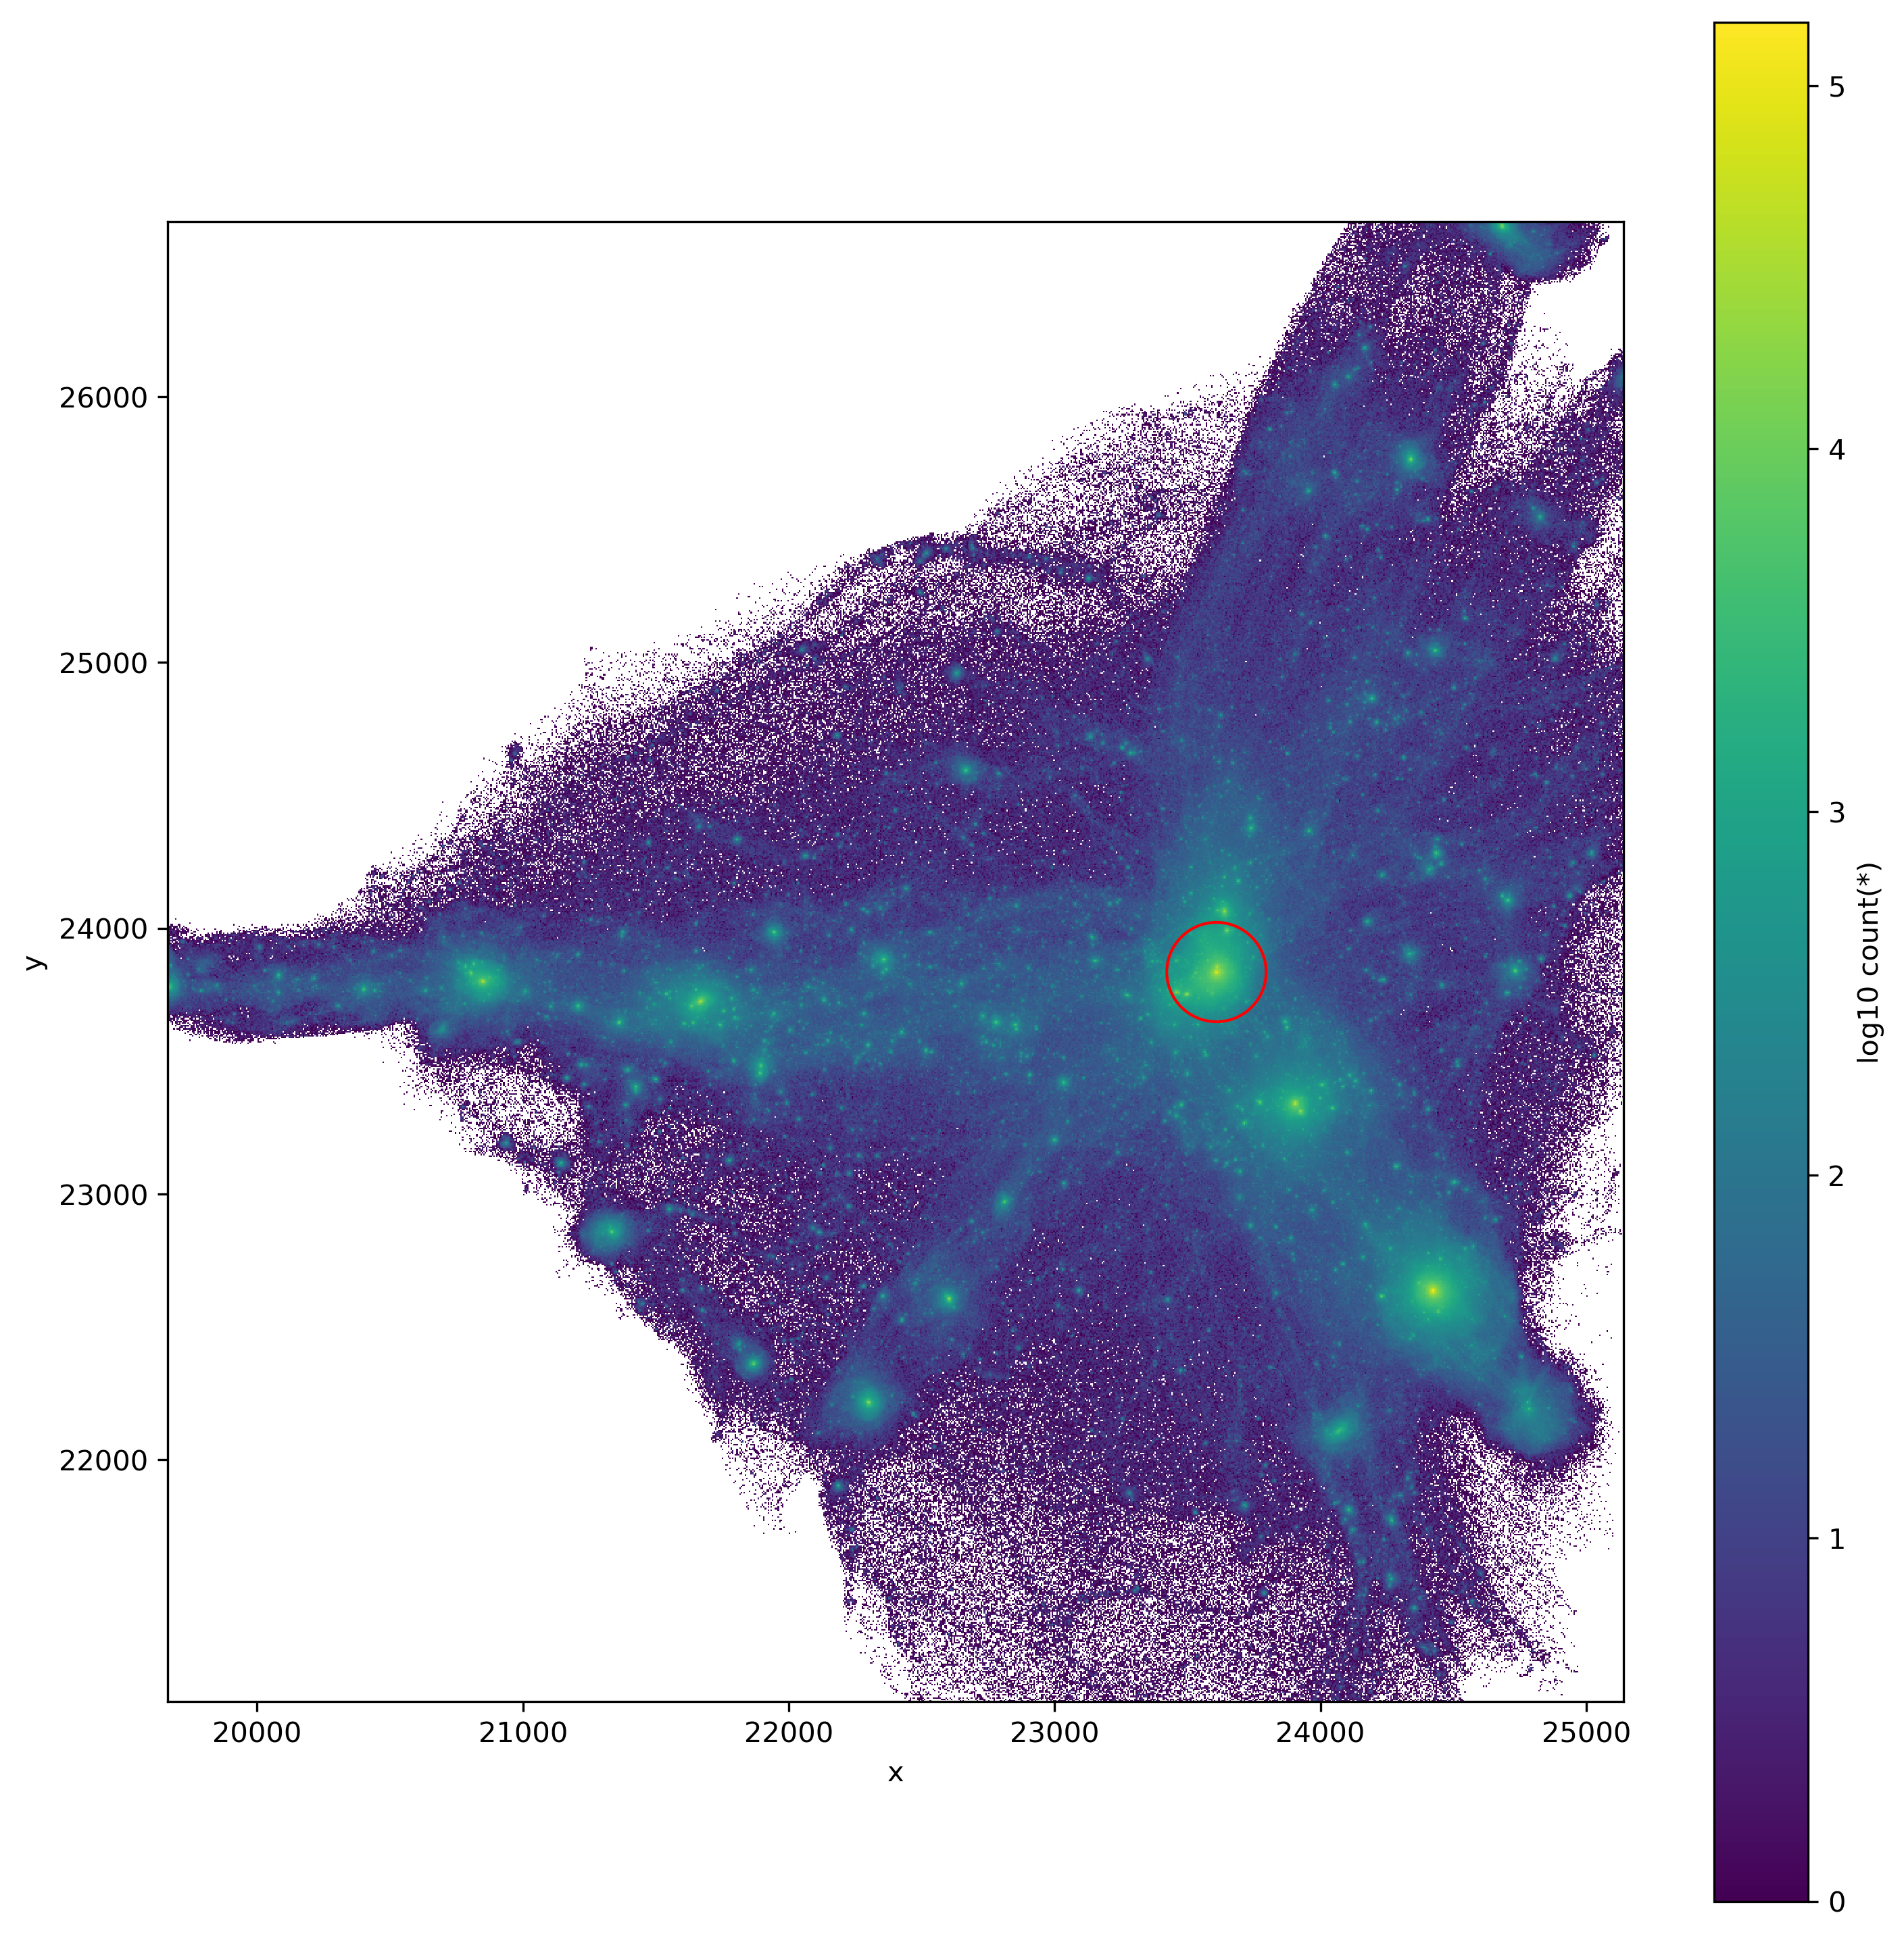

In [6]:
plt.figure(figsize=(10, 10), dpi=300)

ds = vaex.from_pandas(dm_pos)
ds.plot('x', 'y', f='log10', colormap=plt.cm.viridis, shape=1024)

xc = central.x * 1000
yc = central.y * 1000
zc = central.z * 1000

circle = plt.Circle((xc, yc), central.rvir, color='r', fill=False)

ax = plt.gca()
ax.add_artist(circle)

ax.set_aspect('equal')

In [7]:
# compute bndry particles distance to halo centre

bndry_r = bndry_pos - central[['x', 'y', 'z']] * 1000
bndry_distance = np.sqrt((bndry_r**2).sum(axis=1))

9267 186.925


Text(0.5, 0, 'distance from halo centre [h$^{-1}$ kpc]')

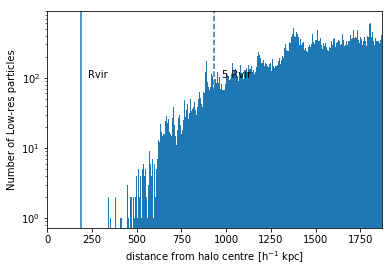

In [8]:
# Plot number of bndry particles as a function of halo distance

rvir = central['rvir']
print(central.name, rvir)

bins = np.linspace(0, 10*rvir, 1000)

h = plt.hist(bndry_distance, bins=bins)

plt.axvline(rvir, linestyle='-')
plt.axvline(5*rvir, linestyle='--')

plt.yscale('log')

plt.xlim(0, 10*rvir)

# set labels
text_margin = 40
text_y = 100
rotation = 0
plt.text(rvir+text_margin, text_y, 'Rvir', rotation=rotation)
plt.text(5*rvir+text_margin, text_y, '5 Rvir', rotation=rotation)

plt.ylabel(r'Number of Low-res particles')
plt.xlabel(r'distance from halo centre [h$^{-1}$ kpc]')

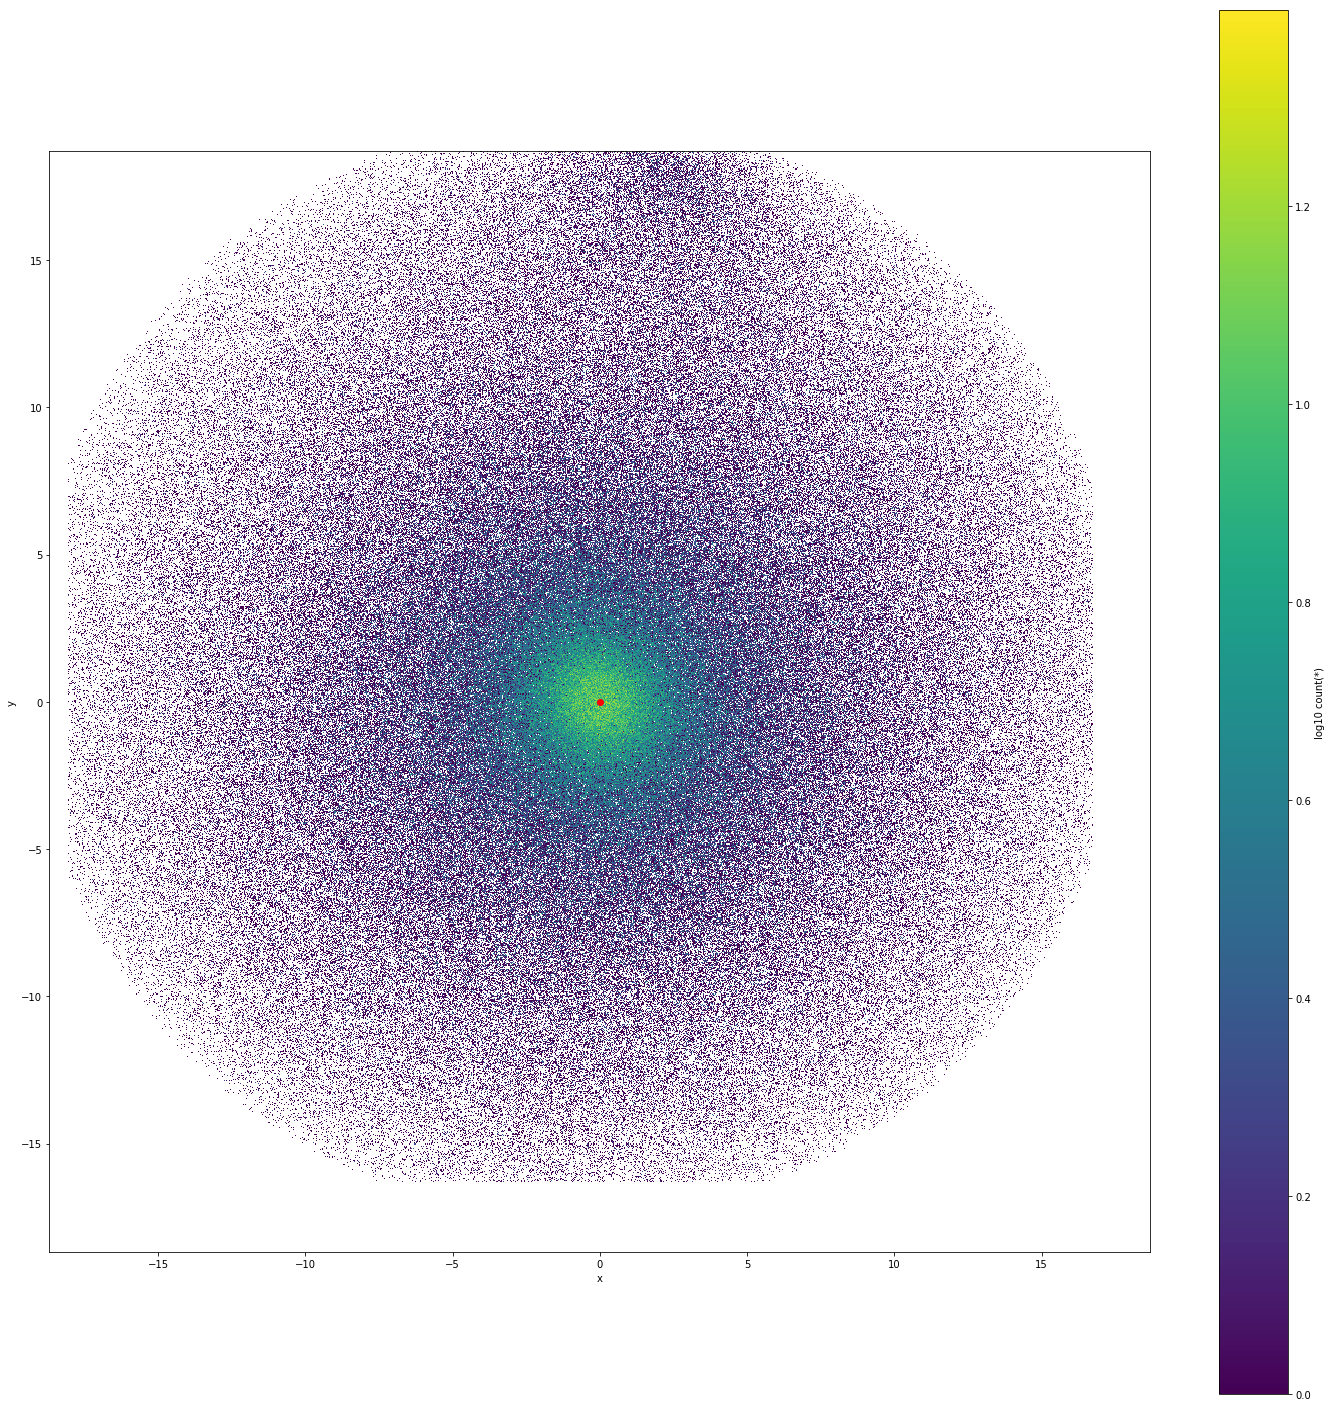

In [9]:
fig = plt.figure(figsize=(20, 20))

rtb = 0.1

xc = central.x * 1000
yc = central.y * 1000
zc = central.z * 1000
    
r = dm_pos[['x', 'y', 'z']] - np.array([xc, yc, zc])
d2 = (r**2).sum(axis=1)
mask = d2 < (rtb*rvir)**2

pot = dm_pot[mask]

min_pot_id = pot.idxmin()

c_pot = (dm_pos.loc[min_pot_id].values - np.array([xc, yc, zc]))[0]

ds = vaex.from_pandas(r[mask] - c_pot)

ds.plot('x', 'y', f='log10', colormap=plt.cm.viridis, shape=1024)

ax = plt.gca()

ax.set_xlim(-rtb*rvir, +rtb*rvir)
ax.set_ylim(-rtb*rvir, +rtb*rvir)

plt.scatter(0, 0, c='r')

ax.set_aspect('equal')

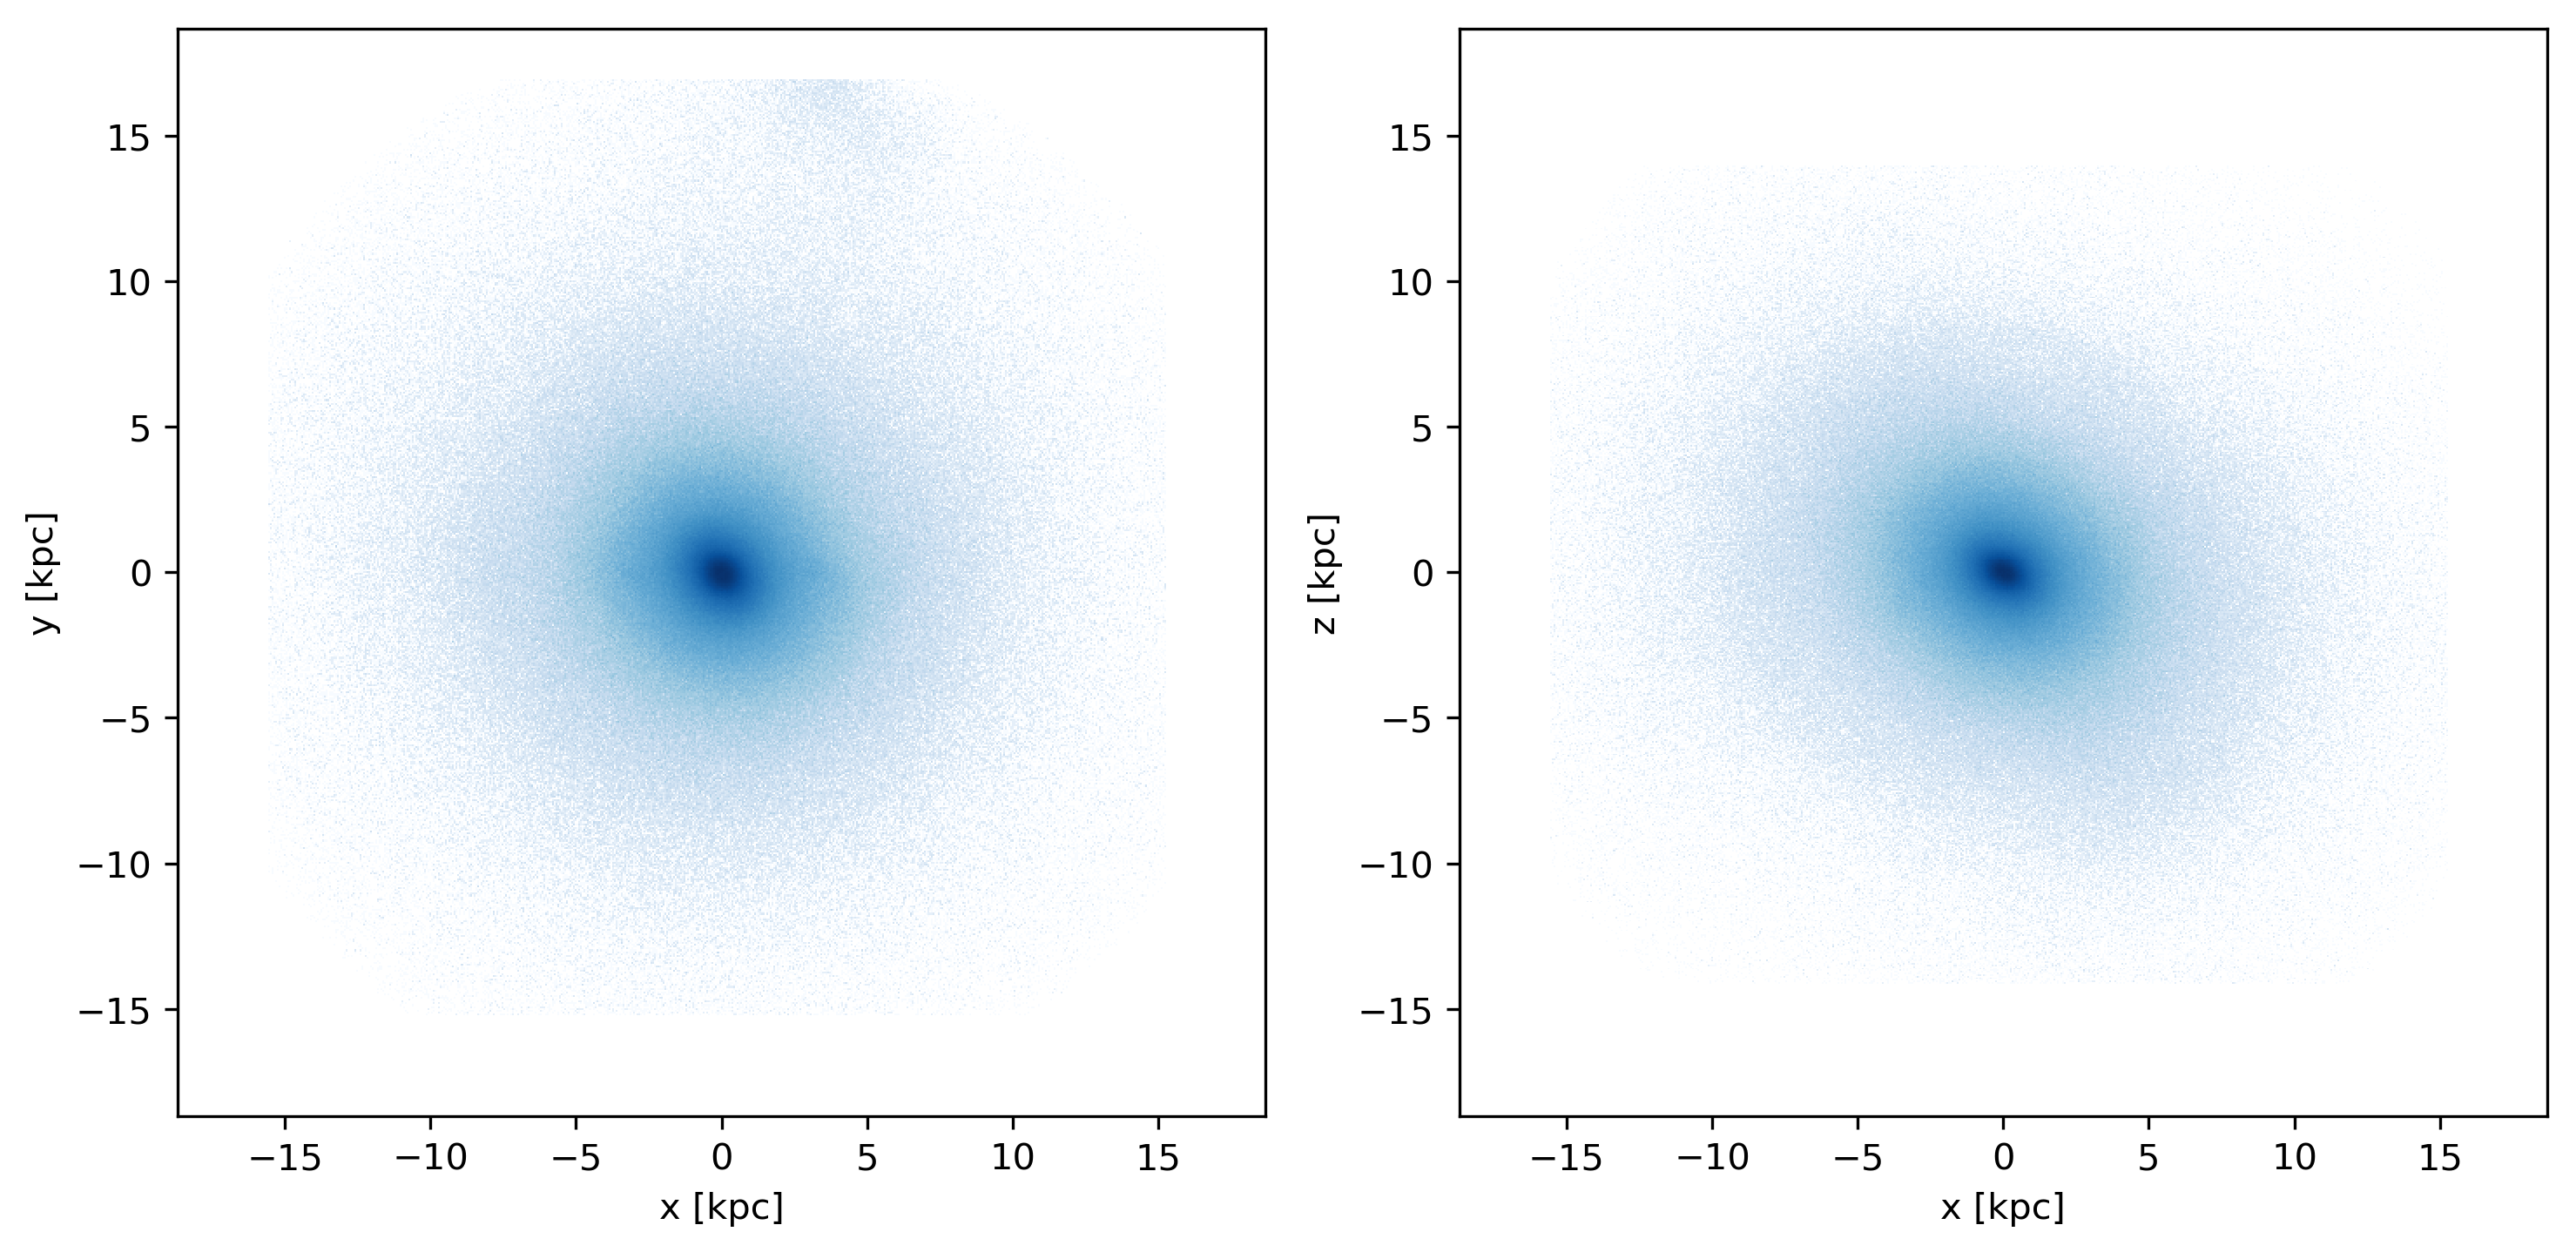

In [10]:
fig = plt.figure(figsize=(10, 20), dpi=300)

rtb = 0.1
shape = 512
colorbar = False
colormap = plt.cm.Blues
f = 'log10'

grid = GridSpec(1, 2)

c_pot = dm_pos.loc[min_pot_id].values[0]

r = stars_pos[['x', 'y', 'z']] - c_pot
d2 = (r**2).sum(axis=1)
mask = d2 < (rtb*rvir)**2

ds = vaex.from_pandas(r[mask])

axis = [['x', 'y'], ['x', 'z']]

for i in range(2):
    
    x = axis[i][0]
    y = axis[i][1]
    
    ax = plt.subplot(grid[i])
    ds.plot(x, y, f=f, colormap=colormap, shape=shape, colorbar=colorbar)

    ax.set_xlim(-rtb*rvir, +rtb*rvir)
    ax.set_ylim(-rtb*rvir, +rtb*rvir)

    ax.set_aspect('equal')
    
    ax.set_xlabel(x + ' [kpc]')
    ax.set_ylabel(y + ' [kpc]')

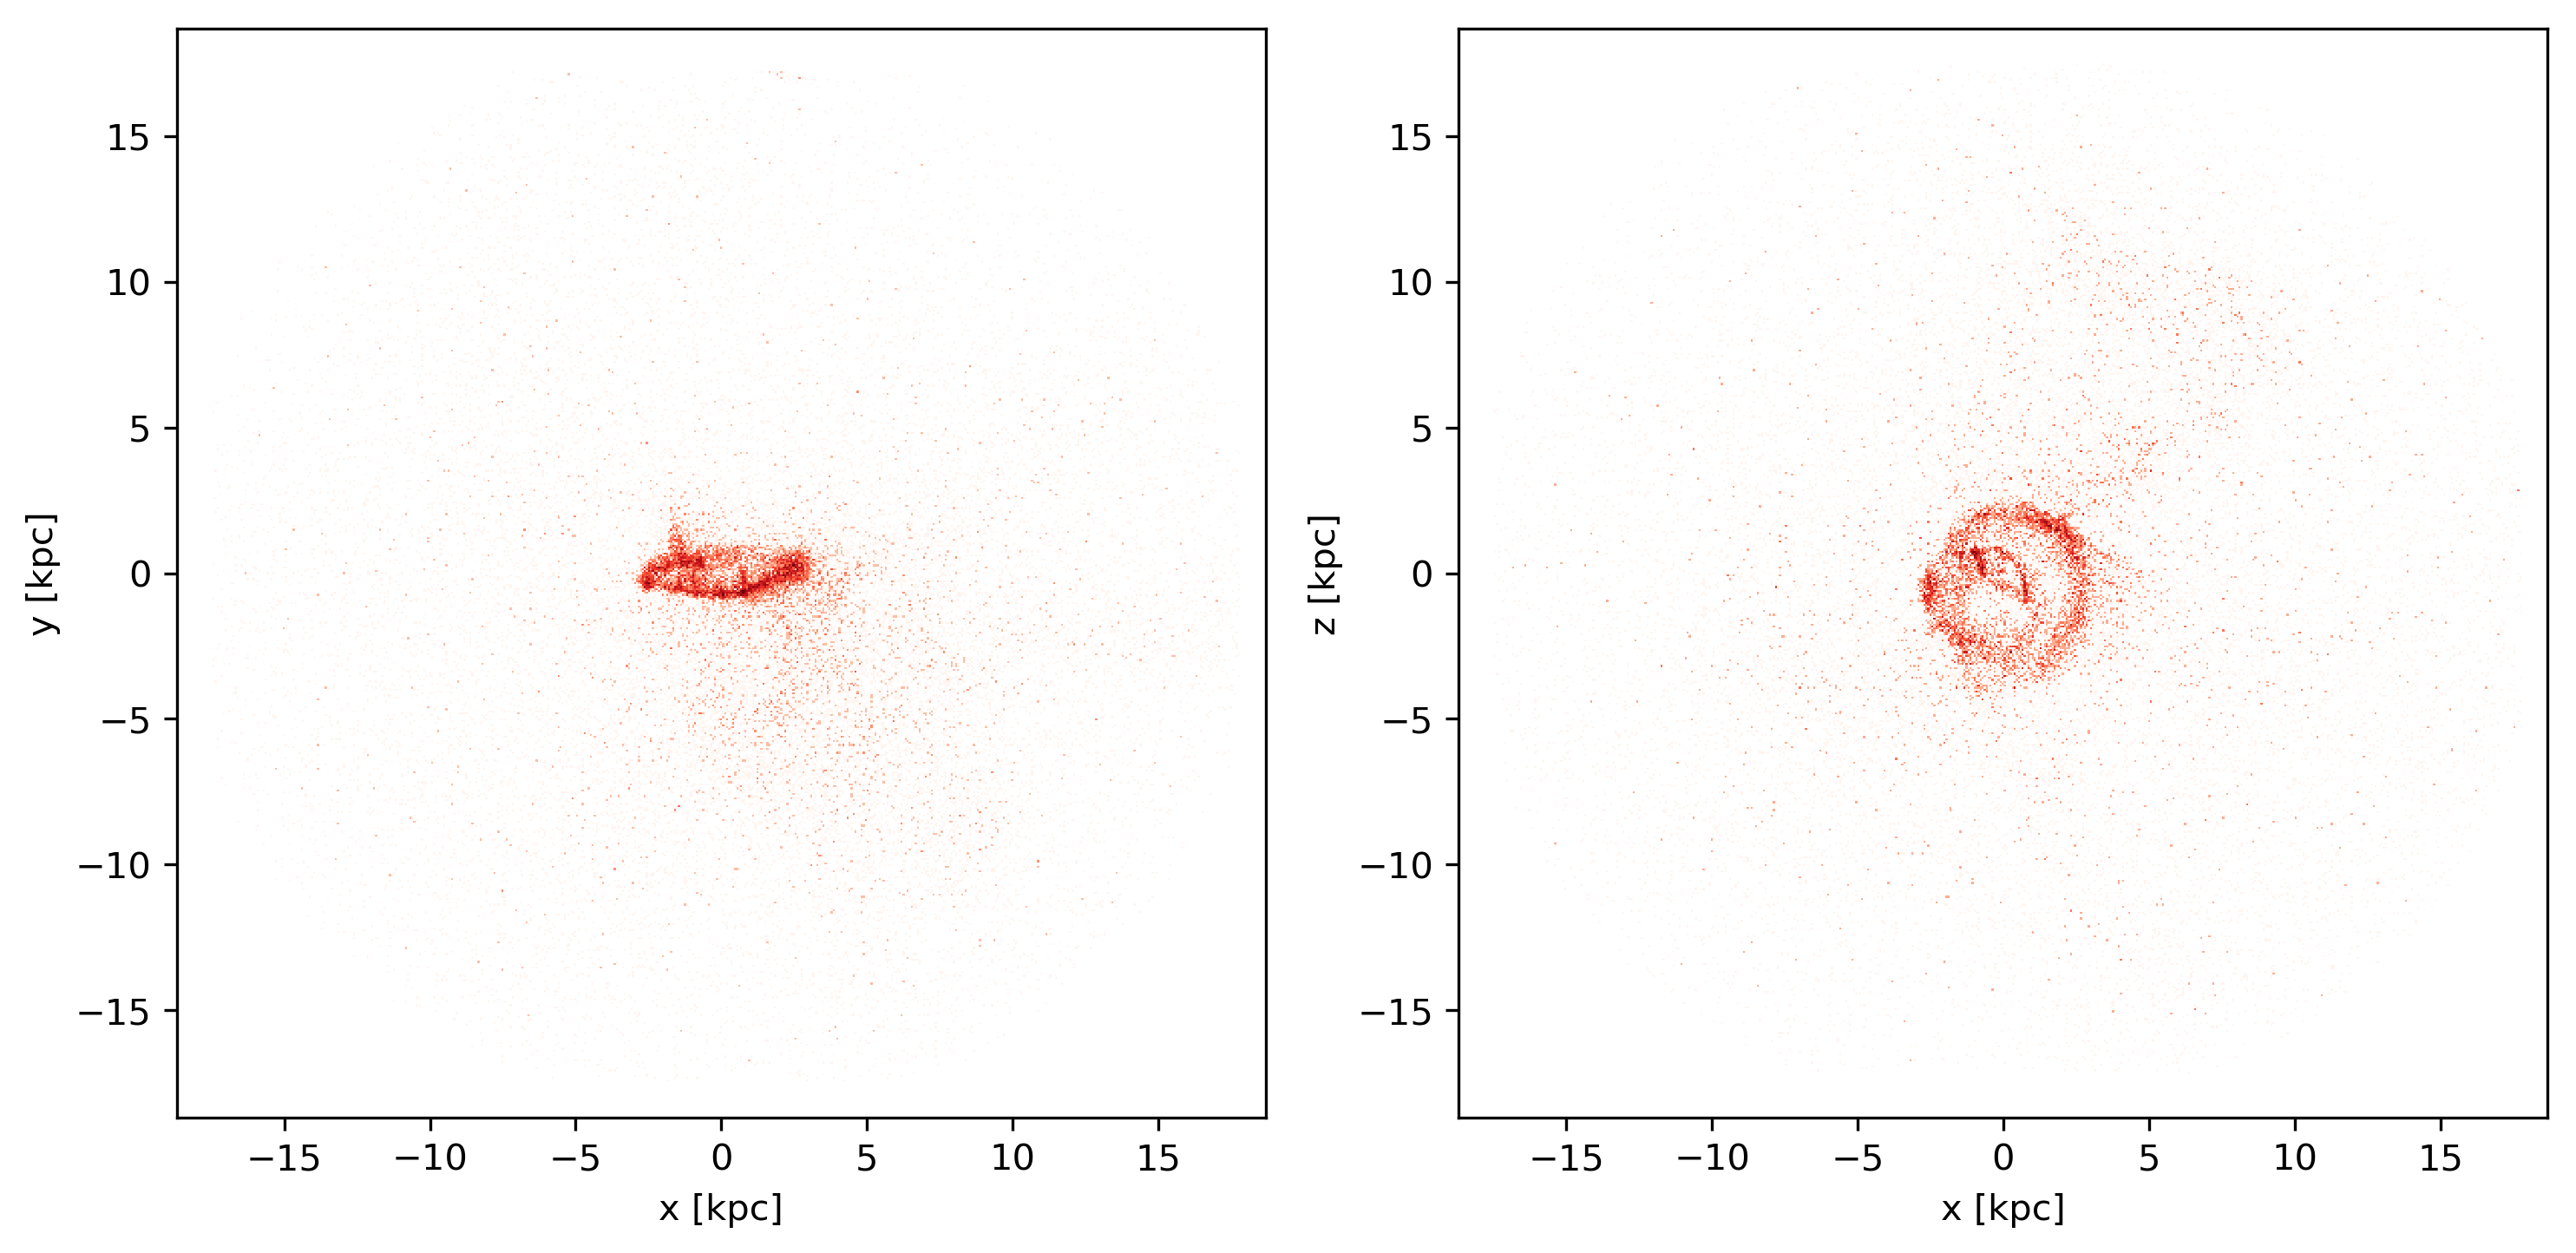

In [11]:
fig = plt.figure(figsize=(10, 20), dpi=300)

rtb = 0.1
shape = 512
colorbar = False
colormap = plt.cm.Reds
f = 'log10'

grid = GridSpec(1, 2)

c_pot = dm_pos.loc[min_pot_id].values[0]

r = gas_pos[['x', 'y', 'z']] - c_pot
d2 = (r**2).sum(axis=1)
mask = d2 < (rtb*rvir)**2

ds = vaex.from_pandas(r[mask])

axis = [['x', 'y'], ['x', 'z']]

for i in range(2):
    
    x = axis[i][0]
    y = axis[i][1]
    
    ax = plt.subplot(grid[i])
    ds.plot(x, y, f=f, colormap=colormap, shape=shape, colorbar=colorbar)

    ax.set_xlim(-rtb*rvir, +rtb*rvir)
    ax.set_ylim(-rtb*rvir, +rtb*rvir)

    ax.set_aspect('equal')
    
    ax.set_xlabel(x + ' [kpc]')
    ax.set_ylabel(y + ' [kpc]')

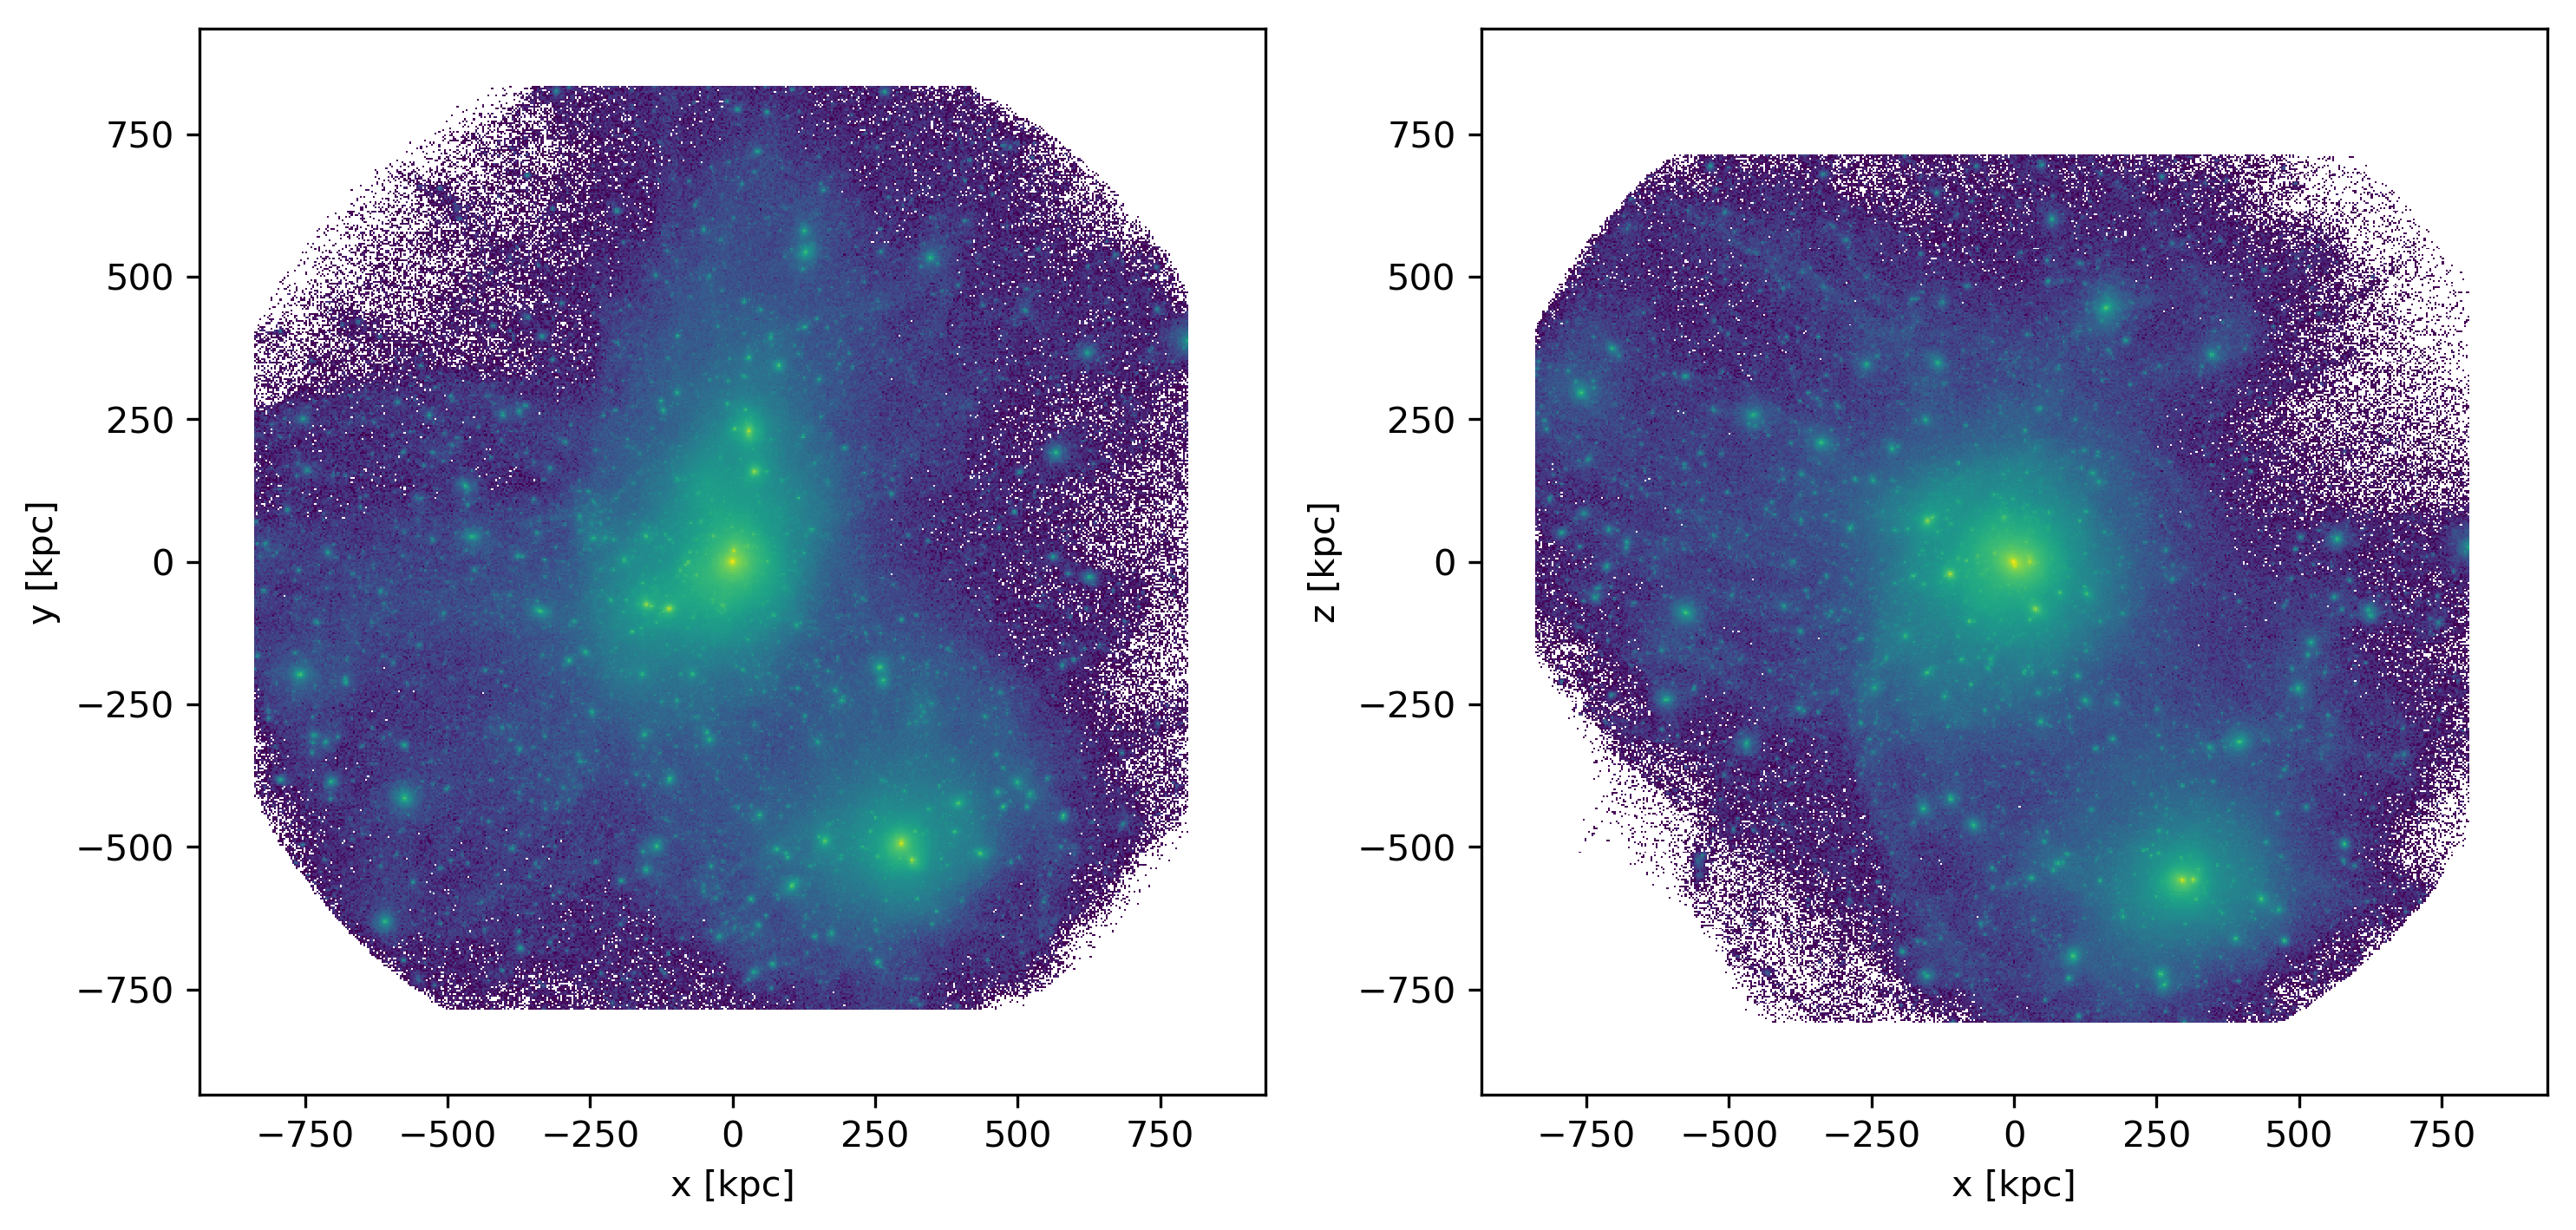

In [12]:
fig = plt.figure(figsize=(10, 20), dpi=300)

rtb = 5
shape = 512
colorbar = False
colormap = plt.cm.viridis
f = 'log10'

grid = GridSpec(1, 2)

c_pot = dm_pos.loc[min_pot_id].values[0]

r = dm_pos[['x', 'y', 'z']] - c_pot
d2 = (r**2).sum(axis=1)
mask = d2 < (rtb*rvir)**2

ds = vaex.from_pandas(r[mask])

axis = [['x', 'y'], ['x', 'z']]

for i in range(2):
    
    x = axis[i][0]
    y = axis[i][1]
    
    ax = plt.subplot(grid[i])
    ds.plot(x, y, f=f, colormap=colormap, shape=shape, colorbar=colorbar)

    ax.set_xlim(-rtb*rvir, +rtb*rvir)
    ax.set_ylim(-rtb*rvir, +rtb*rvir)

    ax.set_aspect('equal')
    
    ax.set_xlabel(x + ' [kpc]')
    ax.set_ylabel(y + ' [kpc]')